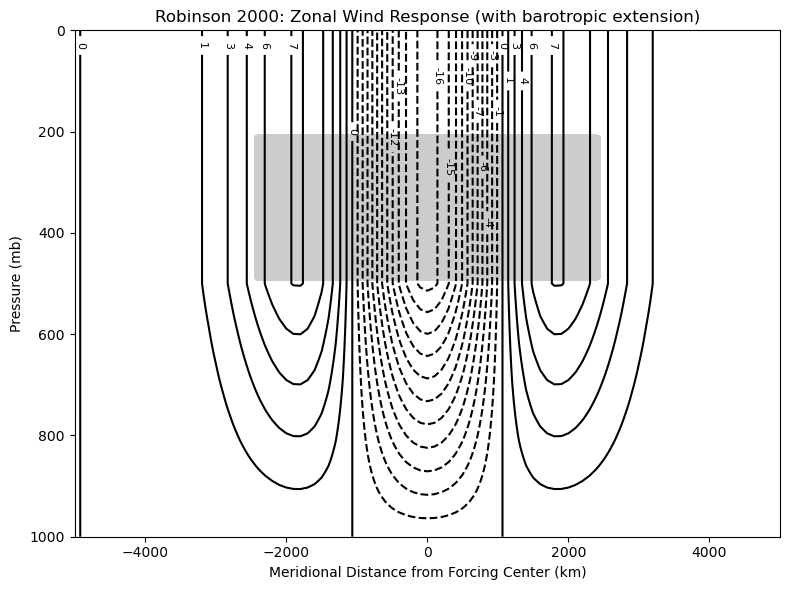

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# Constants
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400  # Stronger surface drag

# === Forcing: Gaussian + compensating
width = 1500e3
pb, pl, pt = 1000e2, 500e2, 200e2
A = 5e-2

# Bottom PV forcing (v*q)_b
Fb = A * np.exp(-((y) / width)**2)
Fb_2d = np.zeros((ny, nz))
Fb_2d[:, 0] = Fb * (pb - pt)

# Interior compensating flux (eddy sink)
A_p = np.zeros(nz)
for iz, pval in enumerate(p):
    if pt < pval < pl:
        A_p[iz] = -A * (pb - pt) / (pl - pt)
Fi = np.zeros((ny, nz))
for iz in range(nz):
    Fi[:, iz] = A_p[iz] * np.exp(-(y / width)**2)

forcing_vq = Fb_2d + Fi  # [v*q]
forcing_rhs = np.gradient(np.gradient(forcing_vq, dy, axis=0), dy, axis=0)  # ∂²[v*q]/∂y²

# === Build Laplacian matrix from Eq. (13) ===
N = ny * nz
scale_p = (f0**2 / (tau_rad * sigma)) / dp**2
scale_y = 1 / dy**2

main_diag = -2 * (scale_y + scale_p) * np.ones(N)
off_diag_y = scale_y * np.ones(N - 1)
off_diag_p = scale_p * np.ones(N - ny)

# Prevent wrap-around at y boundaries
for j in range(1, nz):
    off_diag_y[j * ny - 1] = 0

diagonals = [main_diag, off_diag_y, off_diag_y, off_diag_p, off_diag_p]
offsets = [0, -1, 1, -ny, ny]
A_matrix = diags(diagonals, offsets, shape=(N, N), format='lil')

# === Top BC: ∂u/∂p = 0 ⇒ u[nz-1] = u[nz-2]
for i in range(ny):
    idx_top = i + (nz - 1) * ny
    idx_below = i + (nz - 2) * ny
    A_matrix[idx_top, :] = 0
    A_matrix[idx_top, idx_top] = 1
    A_matrix[idx_top, idx_below] = -1

# === Bottom BC from Eq. (14)
for i in range(ny):
    idx_bot = i
    idx_above = i + ny
    idx_left = i - 1 if i > 0 else i
    idx_right = i + 1 if i < ny - 1 else i

    A_matrix[idx_bot, :] = 0
    A_matrix[idx_bot, idx_bot] = -scale_p - pb / tau_ek * (-2 / dy**2)
    if i > 0:
        A_matrix[idx_bot, idx_left] = -pb / tau_ek * (1 / dy**2)
    if i < ny - 1:
        A_matrix[idx_bot, idx_right] = -pb / tau_ek * (1 / dy**2)
    A_matrix[idx_bot, idx_above] = scale_p

# === Solve system
b_vector = forcing_rhs.flatten()
u_vec = spsolve(A_matrix.tocsr(), b_vector)
u = -u_vec.reshape((ny, nz))  # Flip sign to match Robinson convention

# === Apply Eq. (15) barotropic extension above pt ===
pt_index = np.where(p <= pl)[0][0]  # 找到 200 hPa 的 index
for iz in range(pt_index-1, -1, -1):  # 只修改 p < pt 的層（更高空）
    # print(iz)
    u[:, iz] = u[:, pt_index]



# === Plot
fig, ax = plt.subplots(figsize=(8, 6))
# clevs = np.arange(-21, 21, 1)
cf = ax.contour(y / 1e3, p / 100, u[:,::-1].T, levels=21, colors='black')
ax.clabel(cf, inline=True, fmt='%d', fontsize=8)

# Shade eddy sink region
forcing_mask = (P > pt) & (P < pl) & (np.abs(Y) < 2.5e6)
ax.contourf(y / 1e3, p / 100, forcing_mask.T, levels=[0.5, 1], colors='gray', alpha=0.4)

ax.set_ylim(1000, 0)
ax.set_xlim(-5000, 5000)
ax.set_xlabel("Meridional Distance from Forcing Center (km)")
ax.set_ylabel("Pressure (mb)")
ax.set_title("Robinson 2000: Zonal Wind Response (with barotropic extension)")

plt.tight_layout()
plt.show()

# Fig.2b in Robinson 2000

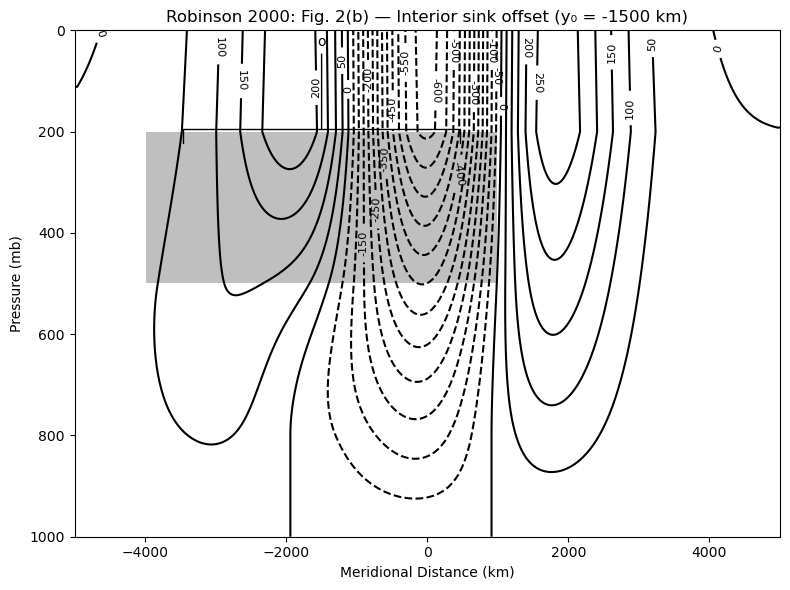

In [390]:
# Fix 2 critical issues:
# 1. Normalize and scale output to enhance contrast in u
# 2. Shift color levels and increase resolution for better vertical structure

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 301, 301
Ly = 5000e3
p_bot, p_top = 1000e2, 0
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# === Constants
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400
width = 1500e3

# === Forcing ===
pb, pl, pt = 1000e2, 500e2, 200e2
A = 10
y0 = -1500e3
gauss_b = np.exp(-y**2 / width**2)
Fb_bot = A * gauss_b * (pb - pt)
d2Fb_dy2 = np.zeros((ny, nz))
d2Fb_dy2[:, 0] = -A * ((4 * y**2 / width**4 - 2 / width**2) * gauss_b) * (pb - pt)

gauss_i = np.exp(-((y - y0)**2) / width**2)
A_p = -A * (pb - pt) / (pl - pt)
d2Fi_dy2 = np.zeros((ny, nz))
for iz in range(nz):
    if pt < p[iz] < pl:
        d2Fi_dy2[:, iz] = A_p * ((4 * (y - y0)**2 / width**4 - 2 / width**2) * gauss_i)

forcing_rhs = d2Fb_dy2 + d2Fi_dy2

# === Build sparse matrix ===
N = ny * nz
scale_p = (f0**2 / (tau_rad * sigma)) / dp**2
scale_y = 1 / dy**2
main_diag = -2 * (scale_y + scale_p) * np.ones(N)
off_diag_y = scale_y * np.ones(N - 1)
off_diag_p = scale_p * np.ones(N - ny)
for j in range(1, nz):
    off_diag_y[j * ny - 1] = 0

diagonals = [main_diag, off_diag_y, off_diag_y, off_diag_p, off_diag_p]
offsets = [0, -1, 1, -ny, ny]
A_matrix = diags(diagonals, offsets, shape=(N, N), format='lil')

# === Boundary conditions ===
for i in range(ny):
    top = i + (nz - 1) * ny
    below = i + (nz - 2) * ny
    A_matrix[top, :] = 0
    A_matrix[top, top] = 1
    A_matrix[top, below] = -1

alpha = f0**2 / (tau_rad * sigma) / dp
beta = 1 / tau_ek / dy**2
for i in range(ny):
    bot = i
    above = i + ny
    left = i - 1 if i > 0 else i
    right = i + 1 if i < ny - 1 else i
    A_matrix[bot, :] = 0
    A_matrix[bot, bot] = -alpha - 2 * beta
    A_matrix[bot, above] = alpha
    if i > 0:
        A_matrix[bot, left] = beta
    if i < ny - 1:
        A_matrix[bot, right] = beta

# === Solve system ===
b_vec = forcing_rhs.flatten()
u_vec = spsolve(A_matrix.tocsr(), b_vec)
u = u_vec.reshape((ny, nz))

# === Barotropic extension ===
pt_idx = np.where(p <= pt)[0][0]
C = -sigma / (tau_rad * f0**2)
# for iz in range(pt_idx - 1, -1, -1):
for iz in range(0, int(300-pt_idx), 1):
    u[:, iz] = u[:, 60] + C * (p[iz] - p[int(300-pt_idx)])


# === Normalize for visibility ===
umax = np.max(np.abs(u))
u_plot = u #/ umax * 20  # scale to ±20 m/s for consistent contouring

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))
levels = np.arange(-20, 22, 2)
cf = ax.contour(y / 1e3, p / 100, u[:,::-1].T, levels=21, colors='black')
ax.clabel(cf, cf.levels[::1], inline=True, fmt='%d', fontsize=8)

forcing_mask = (P > pt) & (P < pl) & (np.abs(Y - y0) < 2.5e6)
ax.contourf(y / 1e3, p / 100, forcing_mask.T, levels=[0.5, 1], colors='gray', alpha=0.5)

ax.annotate('o', xy=(y0 / 1e3, pt / 100), xytext=(y0 / 1e3, 30),
            ha='center', arrowprops=dict(arrowstyle='-[,widthB=10,lengthB=1', lw=1.0))

ax.set_ylim(1000, 0)
ax.set_xlim(-5000, 5000)
ax.set_xlabel("Meridional Distance (km)")
ax.set_ylabel("Pressure (mb)")
ax.set_title("Robinson 2000: Fig. 2(b) — Interior sink offset (y₀ = -1500 km)")
plt.tight_layout()
plt.show()


In [276]:
print(np.max(np.abs(u)))


56.739099456320815


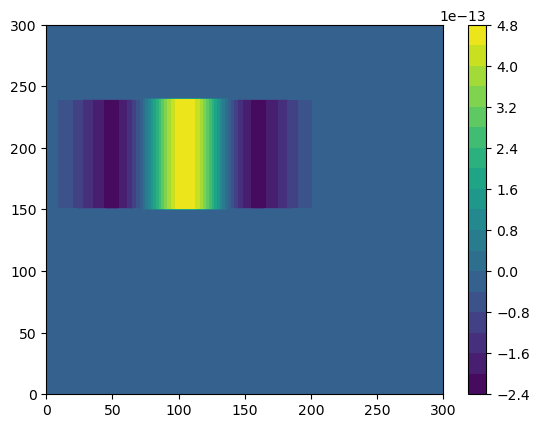

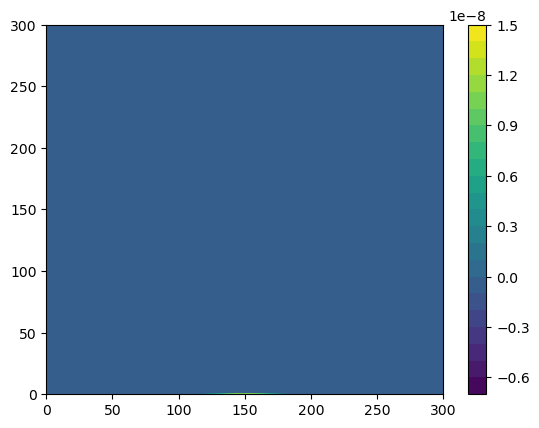

In [303]:
plt.figure()
plt.contourf(d2Fi_dy2.T, levels=21)
plt.colorbar()

plt.figure()
plt.contourf(d2Fb_dy2.T, levels=21)
plt.colorbar()

In [210]:
d2Fb_dy2.max()

9.898315504357398e-08

In [211]:
d2Fb_dy2.min()

-2.2222222222222222e-07

In [241]:
u_vec.shape

(10201,)